# Dependencies
1. tensorflow
2. OpenCV
3. Mediapipe
4. Scikit Learn
5. Matplotlib

### Installing all the above dependencies

In [444]:
!pip install matplotlib scikit-learn mediapipe opencv-python tensorflow

In [469]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import mediapipe as mp
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
import os
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from tensorflow.keras.layers import LSTM, Dense
import cv2
from keras.layers import Dense, Conv2D, Flatten
import math


# MediaPipe Holistic
The MediaPipe Holistic Landmarker task lets you combine components of the pose, face, and hand landmarkers to create a complete landmarker for the human body. You can use this task to analyze full-body gestures, poses, and actions. This task uses a machine learning (ML) model on a continuous stream of images. 

### Collecting video and converting BGR to RGB

In [446]:
def Image_processing(picture, model):
    picture = cv2.cvtColor(picture, cv2.COLOR_BGR2RGB) 
    picture.flags.writeable = False                    
    results = model.process(picture)                   
    picture.flags.writeable = True                     
    picture = cv2.cvtColor(picture, cv2.COLOR_RGB2BGR)
    return picture, results

# Mediapipe Holistic Pipeline
To streamline the identification of ROIs for face and hands, it utilize a tracking approach similar to the one we use for standalone face and hand pipelines.
#### mp.solutions.holistic -> Creates a holistic model
#### mp.solutions.drawing_utils -> Creates drawings of landmark connections.

In [447]:
holistic_model = mp.solutions.holistic 
connections = mp.solutions.drawing_utils

# Collect Landmarks and connect them
1. Right hand
2. Left hand
3. Pose
4. Face

In [448]:
# Draw landmarks(coordinate points) on the user
right_hand = results.right_hand_landmarks
left_hand = results.left_hand_landmarks
body = results.pose_landmarks
Face = results.face_landmarks

# Connect the above collected landmarks
hand_connections = holistic_model.HAND_CONNECTIONS
body_connections = holistic_model.POSE_CONNECTIONS
Face_connections = holistic_model.FACEMESH_CONTOURS

In [449]:
print(hand_connections)

frozenset({(3, 4), (0, 5), (17, 18), (0, 17), (13, 14), (13, 17), (18, 19), (5, 6), (5, 9), (14, 15), (0, 1), (9, 10), (1, 2), (9, 13), (10, 11), (19, 20), (6, 7), (15, 16), (2, 3), (11, 12), (7, 8)})


In [450]:
print(body_connections)

frozenset({(15, 21), (16, 20), (18, 20), (3, 7), (14, 16), (23, 25), (28, 30), (11, 23), (27, 31), (6, 8), (15, 17), (24, 26), (16, 22), (4, 5), (5, 6), (29, 31), (12, 24), (23, 24), (0, 1), (9, 10), (1, 2), (0, 4), (11, 13), (30, 32), (28, 32), (15, 19), (16, 18), (25, 27), (26, 28), (12, 14), (17, 19), (2, 3), (11, 12), (27, 29), (13, 15)})


In [451]:
print(Face_connections)

frozenset({(270, 409), (176, 149), (37, 0), (84, 17), (318, 324), (293, 334), (386, 385), (7, 163), (33, 246), (17, 314), (374, 380), (251, 389), (390, 373), (267, 269), (295, 285), (389, 356), (173, 133), (33, 7), (377, 152), (158, 157), (405, 321), (54, 103), (263, 466), (324, 308), (67, 109), (409, 291), (157, 173), (454, 323), (388, 387), (78, 191), (148, 176), (311, 310), (39, 37), (249, 390), (144, 145), (402, 318), (80, 81), (310, 415), (153, 154), (384, 398), (397, 365), (234, 127), (103, 67), (282, 295), (338, 297), (378, 400), (127, 162), (321, 375), (375, 291), (317, 402), (81, 82), (154, 155), (91, 181), (334, 296), (297, 332), (269, 270), (150, 136), (109, 10), (356, 454), (58, 132), (312, 311), (152, 148), (415, 308), (161, 160), (296, 336), (65, 55), (61, 146), (78, 95), (380, 381), (398, 362), (361, 288), (246, 161), (162, 21), (0, 267), (82, 13), (132, 93), (314, 405), (10, 338), (178, 87), (387, 386), (381, 382), (70, 63), (61, 185), (14, 317), (105, 66), (300, 293), 

In [452]:
def make_connections(image, results):
    connections.draw_landmarks(image, results.right_hand_landmarks, hand_connections) 
    connections.draw_landmarks(image, results.left_hand_landmarks, hand_connections) 
    connections.draw_landmarks(image, results.pose_landmarks, body_connections) 
    connections.draw_landmarks(image, results.face_landmarks, Face_connections) 

### Added some styling to for better appearance of landmarks on the video

In [453]:
def apply_design_on_landmarks(image, results):
    connections.draw_landmarks(image, results.face_landmarks, Face_connections, 
                             connections.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             connections.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    connections.draw_landmarks(image, results.pose_landmarks, body_connections,
                             connections.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             connections.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    connections.draw_landmarks(image, results.left_hand_landmarks, hand_connections, 
                             connections.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             connections.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    connections.draw_landmarks(image, results.right_hand_landmarks, hand_connections, 
                             connections.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             connections.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

## Using OpenCV to capture the user video

After capturing video it is send to draw landmarks and making connections between these landmarks.

In [454]:
video = cv2.VideoCapture(0)
with holistic_model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while video.isOpened():
        ret, frame = video.read()
        image, results = Image_processing(frame, holistic)
        apply_design_on_landmarks(image, results)
        cv2.imshow('Recording', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    video.release()
    cv2.destroyAllWindows()

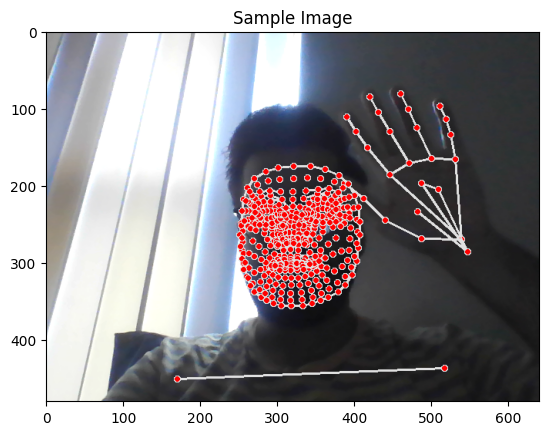

In [455]:
make_connections(frame, results)
plt.title('Sample Image')
photo = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(photo)

# Extract Keypoints
Collecting the X, Y, and Z coordinates of the landmarks and storing them as an array.
If no landmark detected just padding zeroes in the array.


In [456]:
def extract_pose_keypoint(results):
    flattened_pose_landmarks = []
    if results.pose_landmarks:
        landmark_data = []
        for res in results.pose_landmarks.landmark:
            test1 = np.array([res.x, res.y, res.z, res.visibility])
            landmark_data.append(test1)
        flattened_pose_landmarks = np.array(landmark_data).flatten()
    else:
        flattened_pose_landmarks = np.zeros(132)
    return flattened_pose_landmarks

def extract_face_keypoint(results):
    flattened_face_landmarks = []
    if results.face_landmarks:
        landmark_data = []
        for res in results.face_landmarks.landmark:
            test2 = np.array([res.x, res.y, res.z])
            landmark_data.append(test2)
        flattened_face_landmarks = np.array(landmark_data).flatten()
    else:
        flattened_face_landmarks = np.zeros(1404)
    return flattened_face_landmarks

def extract_left_hand_keypoint(results):
    flattened_left_hand_landmarks = []
    if results.left_hand_landmarks:
        landmark_data = []
        for res in results.left_hand_landmarks.landmark:
            test3 = np.array([res.x, res.y, res.z])
            landmark_data.append(test3)
        flattened_left_hand_landmarks = np.array(landmark_data).flatten()
    else:
        flattened_left_hand_landmarks = np.zeros(63)
    return flattened_left_hand_landmarks

def extract_right_hand_keypoint(results):
    flattened_right_hand_landmarks = []
    if results.right_hand_landmarks:
        landmark_data = []
        for res in results.right_hand_landmarks.landmark:
            test4 = np.array([res.x, res.y, res.z])
            landmark_data.append(test4)
        flattened_right_hand_landmarks = np.array(landmark_data).flatten()
    else:
        flattened_right_hand_landmarks = np.zeros(63)
    return flattened_right_hand_landmarks


In [457]:
def feature_extraction(results):
    rh = extract_right_hand_keypoint(results)
    lh = extract_left_hand_keypoint(results)
    pose = extract_pose_keypoint(results)
    face = extract_face_keypoint(results)
    return np.concatenate([pose, face, lh, rh])

In [458]:
print(feature_extraction(results))

[ 0.5097003   0.52161562 -1.33323026 ...  0.          0.
  0.        ]


# Creating folders for data Collection

DATA_PATH -> This is the path for the data. It is a collection of arrays.

gestures -> Actions we are performing for recognition.

no_videos -> Collection of 30 videos

no_frames -> Collection of 30 frames inside each video

In [459]:
DATA_PATH = os.path.join('Generated_Data') 
gestures = np.array(['HELLO', 'THANKS', 'ILOVEYOU'])
no_videos = 30
no_frames = 30

In [460]:
for gesture in gestures: 
    for sequence in range(1,no_videos+1):
        try: 
            directory_path = os.path.join(DATA_PATH, gesture, str(sequence))
            os.makedirs(directory_path)
        except Exception as e:
            print(f"An error occurred while creating directory {directory_path}: {e}")

An error occurred while creating directory Generated_Data\HELLO\1: [WinError 183] Cannot create a file when that file already exists: 'Generated_Data\\HELLO\\1'
An error occurred while creating directory Generated_Data\HELLO\2: [WinError 183] Cannot create a file when that file already exists: 'Generated_Data\\HELLO\\2'
An error occurred while creating directory Generated_Data\HELLO\3: [WinError 183] Cannot create a file when that file already exists: 'Generated_Data\\HELLO\\3'
An error occurred while creating directory Generated_Data\HELLO\4: [WinError 183] Cannot create a file when that file already exists: 'Generated_Data\\HELLO\\4'
An error occurred while creating directory Generated_Data\HELLO\5: [WinError 183] Cannot create a file when that file already exists: 'Generated_Data\\HELLO\\5'
An error occurred while creating directory Generated_Data\HELLO\6: [WinError 183] Cannot create a file when that file already exists: 'Generated_Data\\HELLO\\6'
An error occurred while creating d

# 5. Data collection

Uncomment the below code to collect your own dataset. In this 30 videos will be recorded for each action(Hello, Thanks, Iloveyou). Try to get variance in your data, perform actions with different angle and different positions. Maintain the lighting of the area before doing anything. Also maintain atmost a distance of 3 feet from the camera

In [461]:
# video = cv2.VideoCapture(0)
# with holistic_model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#     for gesture in gestures:
#         for sequence in range(1,no_videos+1):
#             for frame_num in range(no_frames):
#                 ret, frame = video.read()
#                 image, results = Image_processing(frame, holistic)
#                 apply_design_on_landmarks(image, results)
#                 if frame_num == 0: 
#                     cv2.putText(image, 'STARTING COLLECTION', (120,200), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
#                     cv2.putText(image, 'Fetching frame Number {} of Video Number {}'.format(gesture, sequence), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     cv2.imshow('Recording', image)
#                     cv2.waitKey(1000)
#                 else: 
#                     cv2.putText(image, 'Fetching frame Number {} of Video Number {}'.format(gesture, sequence), (15,12), 
#                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
#                     cv2.imshow('Recording', image)
#                 keypoints = feature_extraction(results)
#                 npy_path = os.path.join(DATA_PATH, gesture, str(sequence), str(frame_num))
#                 np.save(npy_path, keypoints)
#                 if cv2.waitKey(10) & 0xFF == ord('q'):
#                     break
                    
#     video.release()
#     cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [462]:
label = zip(gestures, range(len(gestures)))
categories = dict(label)

In [463]:
categories

{'HELLO': 0, 'THANKS': 1, 'ILOVEYOU': 2}

In [464]:
sequences, labels = [], []
for gesture in gestures:
    for sequence in range(1,no_videos+1):
        window = []
        for frame_num in range(no_frames):
            window.append(np.load(os.path.join(DATA_PATH, gesture, str(sequence), "{}.npy".format(frame_num))))
        sequences.append(window)
        labels.append(categories[gesture])

In [465]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Split the data
90% -> Training data

10% -> Test data

In [466]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

# 7. Construct the model 

Below code is the structure of the model. The model structure is a Sequential model instance, with three LSTM layers followed by two dense layers. The LSTM layers allow the model to take temporal information (ordered sequencing of the video data) into account for classification. To do this, LSTM cells propagate information forward as well as to each other (older time steps inform future time steps).  

In [467]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(gestures.shape[0], activation='softmax'))

In [470]:
arr = [2, 3, 4, 1, 2, 5]
sm=0
for i in range(len(arr)):
   sm+=arr[i]
   mean = sm/len(arr)
deviation_sum = 0
for i in range(len(arr)):
   deviation_sum+=(arr[i]- mean)**2
   psd = math.sqrt((deviation_sum)/len(arr))
ssd = math.sqrt((deviation_sum)/len(arr) - 1)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history = model.fit(X_train, y_train, epochs=1000)

Epoch 1/1000
3/3 [==============================] - 5s 35ms/step - loss: 2.7979 - categorical_accuracy: 0.3176
Epoch 2/1000
3/3 [==============================] - 0s 35ms/step - loss: 4.5216 - categorical_accuracy: 0.3294
Epoch 3/1000
3/3 [==============================] - 0s 28ms/step - loss: 2.6041 - categorical_accuracy: 0.2824
Epoch 4/1000
3/3 [==============================] - 0s 36ms/step - loss: 1.1684 - categorical_accuracy: 0.3176
Epoch 5/1000
3/3 [==============================] - 0s 33ms/step - loss: 0.9790 - categorical_accuracy: 0.4588
Epoch 6/1000
3/3 [==============================] - 0s 45ms/step - loss: 1.2287 - categorical_accuracy: 0.4000
Epoch 7/1000
3/3 [==============================] - 0s 47ms/step - loss: 0.9660 - categorical_accuracy: 0.4824
Epoch 8/1000
3/3 [==============================] - 0s 50ms/step - loss: 0.9579 - categorical_accuracy: 0.5882
Epoch 9/1000
3/3 [==============================] - 0s 52ms/step - loss: 0.9014 - categorical_accuracy: 0.4588
E

KeyboardInterrupt: 

In [471]:
history.history??

Type:        dict
String form: {'loss': [2.4847068786621094, 3.7573137283325195, 1.091135859489441, 1.2803906202316284, 2.0257716178894043, 2.3124806880950928, 3.2506039142608643, 1.3761833906173706, 2.363192081451416, 0.9289971590042114], 'categorical_accuracy': [0.24705882370471954, 0.30588236451148987, 0.364705890417099, 0.4000000059604645, 0.364705890417099, 0.34117648005485535, 0.34117648005485535, 0.42352941632270813, 0.42352941632270813, 0.5411764979362488]}
Length:      2
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)

In [472]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy'])

#### These are the accruracy coordinates with respect to number of epochs

In [473]:
history.history['categorical_accuracy']

[0.24705882370471954,
 0.30588236451148987,
 0.364705890417099,
 0.4000000059604645,
 0.364705890417099,
 0.34117648005485535,
 0.34117648005485535,
 0.42352941632270813,
 0.42352941632270813,
 0.5411764979362488]

#### These are the loss coordinates with respect to number of epochs

In [474]:
history.history['loss']

[2.4847068786621094,
 3.7573137283325195,
 1.091135859489441,
 1.2803906202316284,
 2.0257716178894043,
 2.3124806880950928,
 3.2506039142608643,
 1.3761833906173706,
 2.363192081451416,
 0.9289971590042114]

## Plotting a graph for accracy and loss

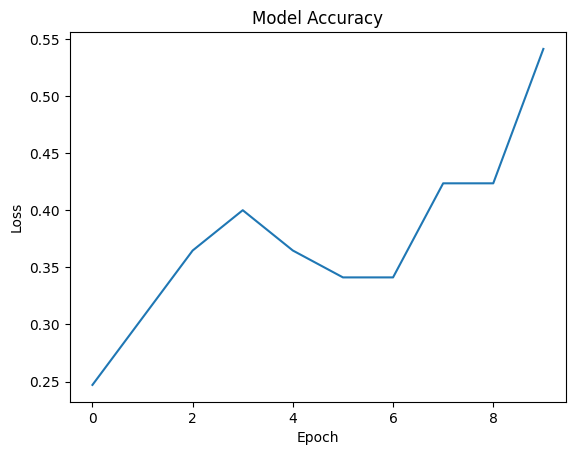

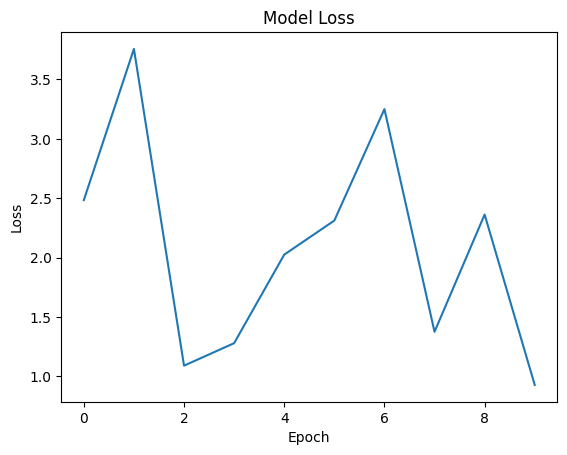

In [475]:
plt.plot(history.history['categorical_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# plt.plot(temp.history['categorical_accuracy'], label='CNN Model')
# plt.plot(temp2.history['categorical_accuracy'], label='LSTM Model')
# plt.title('Training Loss Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

## Model summary 
* Name and type of all layers in the model.
* Output shape for each layer.
* Number of weight parameters of each layer.
* If the model has general topology (discussed below), the inputs each layer receives
* The total number of trainable and non-trainable parameters of the model.

In [476]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 30, 64)            442112    
                                                                 
 lstm_35 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_36 (LSTM)              (None, 64)                49408     
                                                                 
 dense_57 (Dense)            (None, 64)                4160      
                                                                 
 dense_58 (Dense)            (None, 32)                2080      
                                                                 
 dense_59 (Dense)            (None, 3)                 99        
                                                                 
Total params: 596675 (2.28 MB)
Trainable params: 5966

# Testing our Model

In [477]:
res = model.predict(X_test)

1/1 [==============================] - 1s 546ms/step


In [478]:
res.shape

(5, 3)

In [479]:
gestures[np.argmax(res[0])]

'HELLO'

In [480]:
gestures[np.argmax(y_test[0])]

'HELLO'

# Keep the Weights

In [481]:
# model.save('weights.h5')
# model.load_weights('weights.h5')

c:\Users\xyz12\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Verification and Validation

In [482]:
prediction_value = model.predict(X_test)

1/1 [==============================] - 0s 66ms/step


In [483]:
actual = np.argmax(y_test, axis=1)
list_actual = actual.tolist()
prediction = np.argmax(prediction_value, axis=1)
list_predicted = prediction.tolist()

In [484]:
actual_value = list_actual
prediction_value = list_predicted

### Confusion matrix

A confusion matrix is a technique for summarizing the performance of a classification algorithm.

Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset.

Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making.

In [485]:
confusion_matrices = multilabel_confusion_matrix(actual_value, prediction_value)

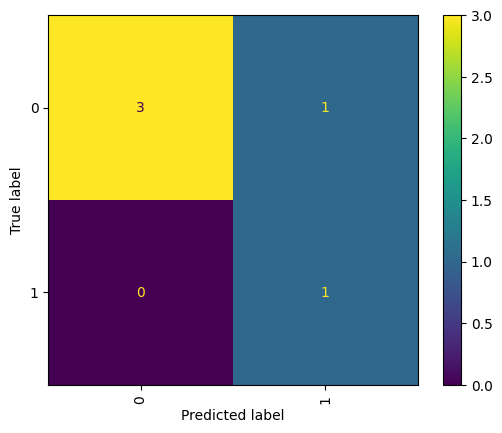

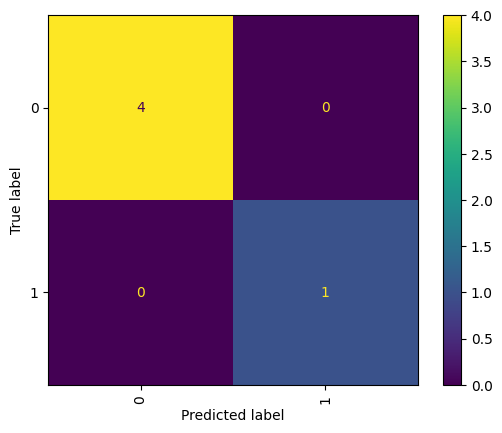

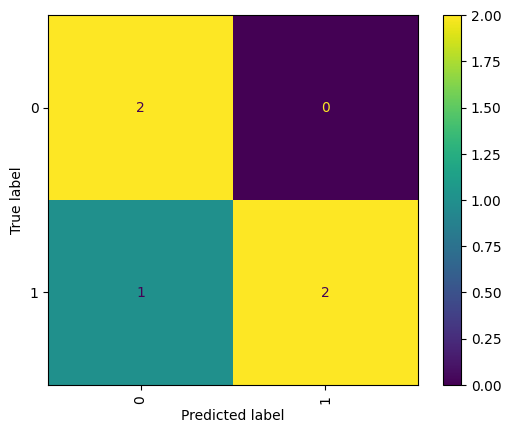

In [486]:
for confusion_matrix in confusion_matrices:
    disp = ConfusionMatrixDisplay(confusion_matrix)
    disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
    plt.show()

In [487]:
print(confusion_matrices)

[[[3 1]
  [0 1]]

 [[4 0]
  [0 1]]

 [[2 0]
  [1 2]]]


### Accuracy Score

Accuracy score in machine learning is an evaluation metric that measures the number of correct predictions made by a model in relation to the total number of predictions made

In [488]:
accuracy_score(actual_value, prediction_value)

0.8

# Live Validation

In [489]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, gestures, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, gestures[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

#### Perform actions like Hello, Thanks, I love you

the model will try to identify the action and display it. Press 'q' to exit.

In [490]:
sequence = []
sentence = []
predictions = []
threshold = 0.4

video = cv2.VideoCapture(0)
with holistic_model.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while video.isOpened():
        ret, frame = video.read()
        image, results = Image_processing(frame, holistic)
        print(results)
        apply_design_on_landmarks(image, results)
        keypoints = feature_extraction(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(gestures[np.argmax(res)])
            predictions.append(np.argmax(res))
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if gestures[np.argmax(res)] != sentence[-1]:
                            sentence.append(gestures[np.argmax(res)])
                    else:
                        sentence.append(gestures[np.argmax(res)])
            if len(sentence) > 5: 
                sentence = sentence[-5:]
            image = prob_viz(res, gestures, image, colors)
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imshow('Recording', image)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    video.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

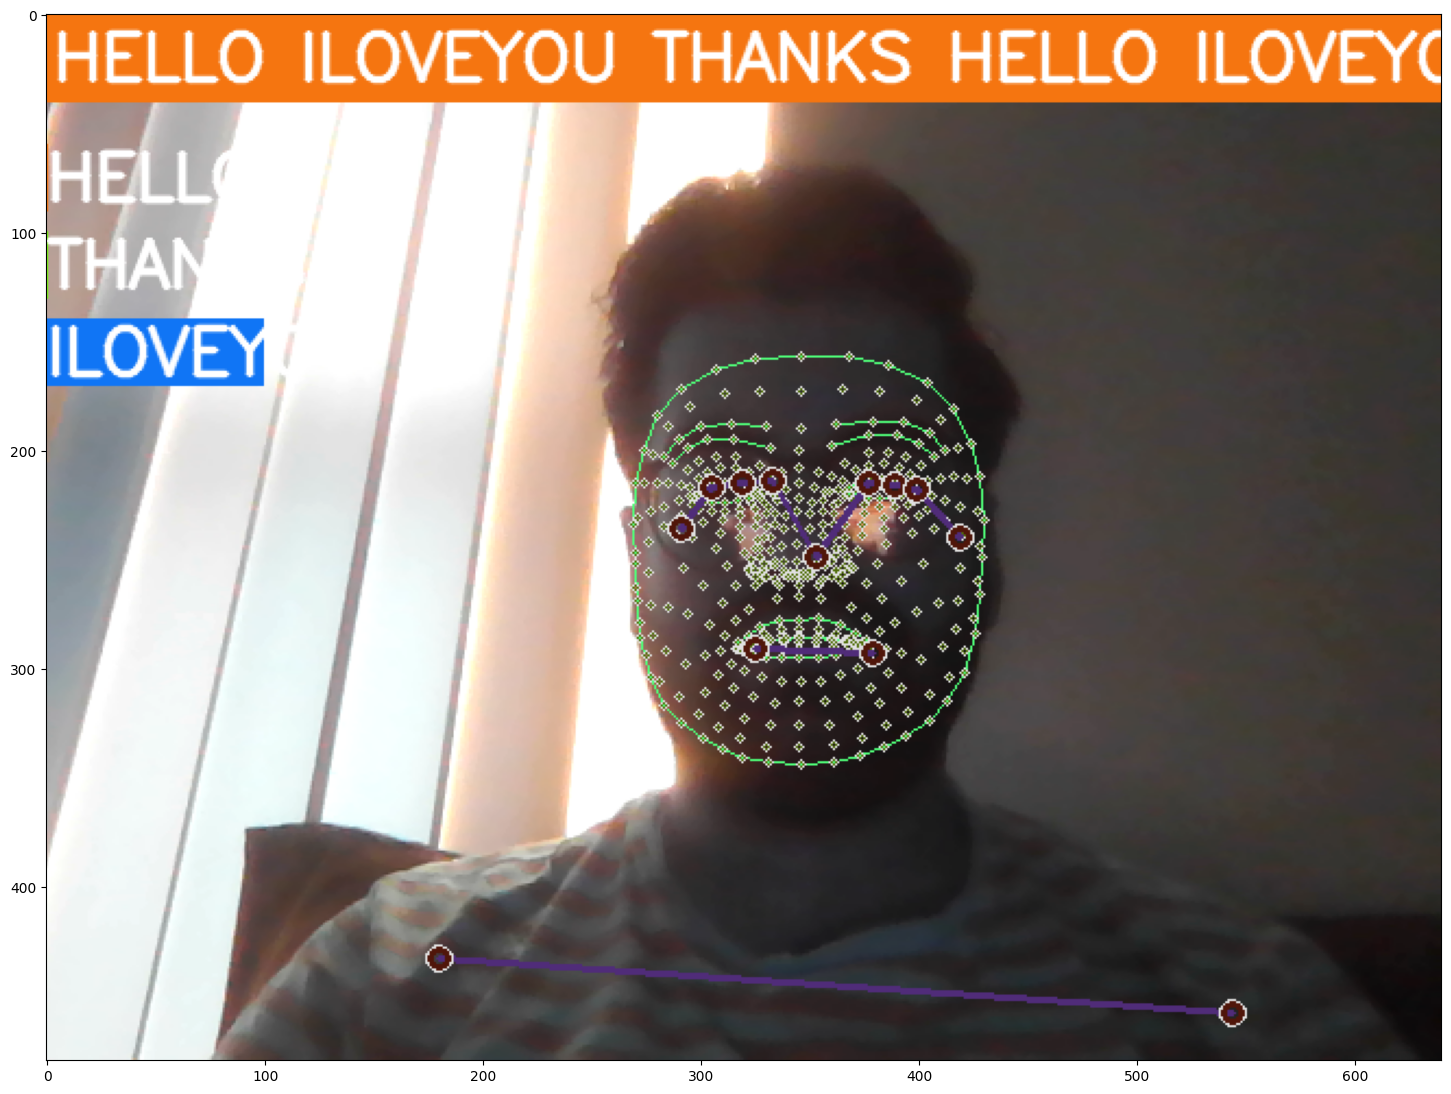

In [491]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, gestures, image, colors))